In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
data = pd.read_csv('cleaned_data.csv')

# Create 'is_paid' feature: 0 for free, 1 for paid
data['is_paid'] = data['Pricing'].apply(lambda x: 0 if x == 0.0 else 1)

# Extract 'Month' from 'Release Date'
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')
data['Release Month'] = data['Release Date'].dt.month

# Filter only free games (is_paid == 0)
data_free = data[data['is_paid'] == 0]

# Select features and target, excluding 'Pricing'
features = ['Game Genre', 'Developer', 'Release Month']
target = 'Rating'

X = data_free[features]
y = data_free[target]

# Reset the index of y to align with X
y = y.reset_index(drop=True)

# Define categorical and numerical features
categorical_features = ['Game Genre', 'Developer']
numerical_features = ['Release Month']

# Preprocessing pipelines for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the preprocessed features to a DataFrame
encoded_cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
encoded_num_features = numerical_features
all_features = list(encoded_cat_features) + encoded_num_features

X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray(), columns=all_features)

# Reset the index of X_preprocessed_df to align with y
X_preprocessed_df = X_preprocessed_df.reset_index(drop=True)

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_df, y, test_size=0.2, random_state=18
)

# Display the sizes of the splits
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')


Training set size: 16585 samples
Test set size: 4147 samples


In [2]:
# Cell 3: Define Parameter Grids for Regression Models
import itertools
# Parameter grids for each model
param_grids = {
    'Ridge': {
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'alpha': [0.1, 1]
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1, 10]
    }
}

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Hàm cross-validation cho hồi quy
def cross_validate_regression(model, X, y, k=5):
    fold_size = len(X) // k
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    scores = {'mse': [], 'rmse': [], 'r2': []}
    
    for fold in range(k):
        start = fold * fold_size
        end = start + fold_size if fold != k-1 else len(X)
        val_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])
        
        # Convert X và y thành numpy arrays nếu là pandas DataFrame hoặc Series
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        X_train_cv, y_train_cv = X[train_indices], y[train_indices]
        X_val_cv, y_val_cv = X[val_indices], y[val_indices]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)
        
        mse = mean_squared_error(y_val_cv, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_cv, y_pred)
        
        scores['mse'].append(mse)
        scores['rmse'].append(rmse)
        scores['r2'].append(r2)
        
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_scores

In [4]:
# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import itertools

# Initialize variables to store the best results and all tuning outcomes for Ridge
ridge_best_score = -np.inf
ridge_best_mse = np.inf
ridge_best_params = {}
ridge_results = []

# Quá trình tuning tham số Ridge Regression
for fit_intercept in param_grids['Ridge']['fit_intercept']:
    for normalize in [True, False]:  # Giờ sử dụng chuẩn hóa với StandardScaler
        # Sử dụng pipeline với StandardScaler và Ridge
        if normalize:
            ridge_model = make_pipeline(StandardScaler(), Ridge(fit_intercept=fit_intercept))
        else:
            ridge_model = Ridge(fit_intercept=fit_intercept)
        
        # Đánh giá mô hình với k-fold cross-validation
        scores = cross_validate_regression(ridge_model, X_train, y_train, k=5)
        
        avg_r2 = scores['r2']
        avg_mse = scores['mse']
        
        # Lưu kết quả vào danh sách
        ridge_results.append({
            'fit_intercept': fit_intercept,
            'normalize': normalize,
            'R2': avg_r2,
            'MSE': avg_mse
        })
        
        # Cập nhật tham số tốt nhất
        if avg_r2 > ridge_best_score and avg_mse < ridge_best_mse:
            ridge_best_score = avg_r2
            ridge_best_mse = avg_mse
            ridge_best_params = {
                'fit_intercept': fit_intercept,
                'normalize': normalize
            }

# In tất cả các kết quả tuning
print("\nAll Ridge parameter tuning results:")
for result in ridge_results:
    print(f"fit_intercept = {result['fit_intercept']}, normalize = {result['normalize']}, R^2 = {result['R2']}, MSE = {result['MSE']}")

# In báo cáo quá trình tuning
print("\nFine-Tuning Ridge Completed!")
print(f"Best parameter: {ridge_best_params}")
print(f"Best R^2: {ridge_best_score}")
print(f"Best MSE: {ridge_best_mse}")

# Huấn luyện lại mô hình với tham số tốt nhất trên toàn bộ tập huấn luyện
if ridge_best_params['normalize']:
    ridge_best_model = make_pipeline(StandardScaler(), Ridge(fit_intercept=ridge_best_params['fit_intercept']))
else:
    ridge_best_model = Ridge(fit_intercept=ridge_best_params['fit_intercept'])

ridge_best_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra và tính toán các chỉ số R², MSE, RMSE
ridge_y_pred_test = ridge_best_model.predict(X_test)
ridge_test_r2 = r2_score(y_test, ridge_y_pred_test)
ridge_test_mse = mean_squared_error(y_test, ridge_y_pred_test)
ridge_test_rmse = np.sqrt(ridge_test_mse)

# In kết quả trên tập kiểm tra
print("\nRidge Test Results:")
print(f"R^2: {ridge_test_r2}")
print(f"MSE: {ridge_test_mse}")
print(f"RMSE: {ridge_test_rmse}")



All Ridge parameter tuning results:
fit_intercept = True, normalize = True, R^2 = -0.05575018756684358, MSE = 283.98494588164294
fit_intercept = True, normalize = False, R^2 = 0.16386429325423632, MSE = 224.80775114748562
fit_intercept = False, normalize = True, R^2 = -19.542695271362824, MSE = 5513.488234866316
fit_intercept = False, normalize = False, R^2 = -0.6464378109688175, MSE = 442.65853530261467

Fine-Tuning Ridge Completed!
Best parameter: {'fit_intercept': True, 'normalize': False}
Best R^2: 0.16386429325423632
Best MSE: 224.80775114748562

Ridge Test Results:
R^2: 0.15481034962390994
MSE: 227.18858758421317
RMSE: 15.072776372792545


- fit_intercept: Setting fit_intercept=True generally leads to better performance compared to False. This indicates that including the intercept term in the model is crucial for capturing the overall trend in the data.
- normalize: The results suggest that normalization (normalize=True) might not be beneficial for this specific dataset. The model with normalize=False achieved better performance metrics.
- The test results show a slight decrease in R-squared (0.1548) and a slight increase in MSE (227.19) compared to the best model on the training data. This is expected as test data is typically more challenging for a model to predict accurately.
- Low R-squared: The R-squared value of 0.1639 indicates that the model explains only a small portion of the variance in the data. This suggests that the model may not be a good fit for the data or that there are other factors influencing the target variable that are not captured in the current model.   


In [5]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Initialize variables to store the best results and all tuning outcomes
lasso_best_score = -np.inf
lasso_best_mse = np.inf
lasso_best_params = {}
lasso_results = []

# Fine-tuning Lasso Regression
for alpha in param_grids['Lasso']['alpha']:
    # Sử dụng pipeline với StandardScaler và Lasso
    model = make_pipeline(StandardScaler(), Lasso(alpha=alpha, random_state=18))
    
    # Đánh giá mô hình với k-fold cross-validation
    scores = cross_validate_regression(model, X_train, y_train, k=5)
    
    avg_r2 = scores['r2']
    avg_mse = scores['mse']
    
    # Lưu kết quả vào danh sách
    lasso_results.append({
        'alpha': alpha,
        'R2': avg_r2,
        'MSE': avg_mse
    })
    
    # Cập nhật tham số tốt nhất
    if avg_r2 > lasso_best_score and avg_mse < lasso_best_mse:
        lasso_best_score = avg_r2
        lasso_best_mse = avg_mse
        lasso_best_params = {'alpha': alpha}

# In tất cả các kết quả tuning
print("\nAll Lasso parameter tuning results:")
for result in lasso_results:
    print(f"alpha = {result['alpha']}, R^2 = {result['R2']}, MSE = {result['MSE']}")

# In báo cáo quá trình tuning
print("\nFine-Tuning Lasso Completed!")
print(f"Best parameter: {lasso_best_params}")
print(f"Best R^2: {lasso_best_score}")
print(f"Best MSE: {lasso_best_mse}")

# Huấn luyện lại mô hình với tham số tốt nhất trên toàn bộ tập huấn luyện
best_lasso_model = make_pipeline(StandardScaler(), Lasso(alpha=lasso_best_params['alpha'], random_state=18))
best_lasso_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra và tính toán các chỉ số R², MSE, RMSE
lasso_y_pred_test = best_lasso_model.predict(X_test)
lasso_test_r2 = r2_score(y_test, lasso_y_pred_test)
lasso_test_mse = mean_squared_error(y_test, lasso_y_pred_test)
lasso_test_rmse = np.sqrt(lasso_test_mse)

# In kết quả trên tập kiểm tra
print("\nLasso Test Results:")
print(f"R^2: {lasso_test_r2}")
print(f"MSE: {lasso_test_mse}")
print(f"RMSE: {lasso_test_rmse}")



All Lasso parameter tuning results:
alpha = 0.01, R^2 = 0.06754108293074115, MSE = 250.6036396978694
alpha = 0.1, R^2 = 0.13642445407665954, MSE = 232.18087762142335
alpha = 1, R^2 = 0.0014046629390945143, MSE = 268.56093953074827
alpha = 10, R^2 = -0.00014848883648137522, MSE = 268.9589070868419

Fine-Tuning Lasso Completed!
Best parameter: {'alpha': 0.1}
Best R^2: 0.13642445407665954
Best MSE: 232.18087762142335

Lasso Test Results:
R^2: 0.13848139959683292
MSE: 231.57784044803384
RMSE: 15.217681835550177


- Alpha controls the strength of the L1 regularization
  - A small alpha (e.g., 0.01) allows for more flexibility, but can lead to overfitting.
  - A large alpha (e.g., 10) introduces strong regularization, which can shrink many coefficients to zero, potentially underfitting the data.
- The results show that an alpha of 0.1 provides a good balance between model complexity and generalization ability.
- The test results show a slight improvement in R-squared (0.1385) and a slight decrease in MSE (231.58) compared to the best model on the training data. This indicates that the model generalizes well to unseen data.

Best Model: Ridge
Best Model R²: 0.15481034962390994
Best Model MSE: 227.18858758421317
Best Model RMSE: 15.072776372792545


C:\Users\PC\AppData\Local\Temp\ipykernel_1004\3466271700.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['Model'], y=results['MSE'], ax=ax[0], palette=colors)
C:\Users\PC\AppData\Local\Temp\ipykernel_1004\3466271700.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['Model'], y=results['RMSE'], ax=ax[1], palette=colors)
C:\Users\PC\AppData\Local\Temp\ipykernel_1004\3466271700.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['Model'], y=results['R²'], ax=ax[2], palette=colors)


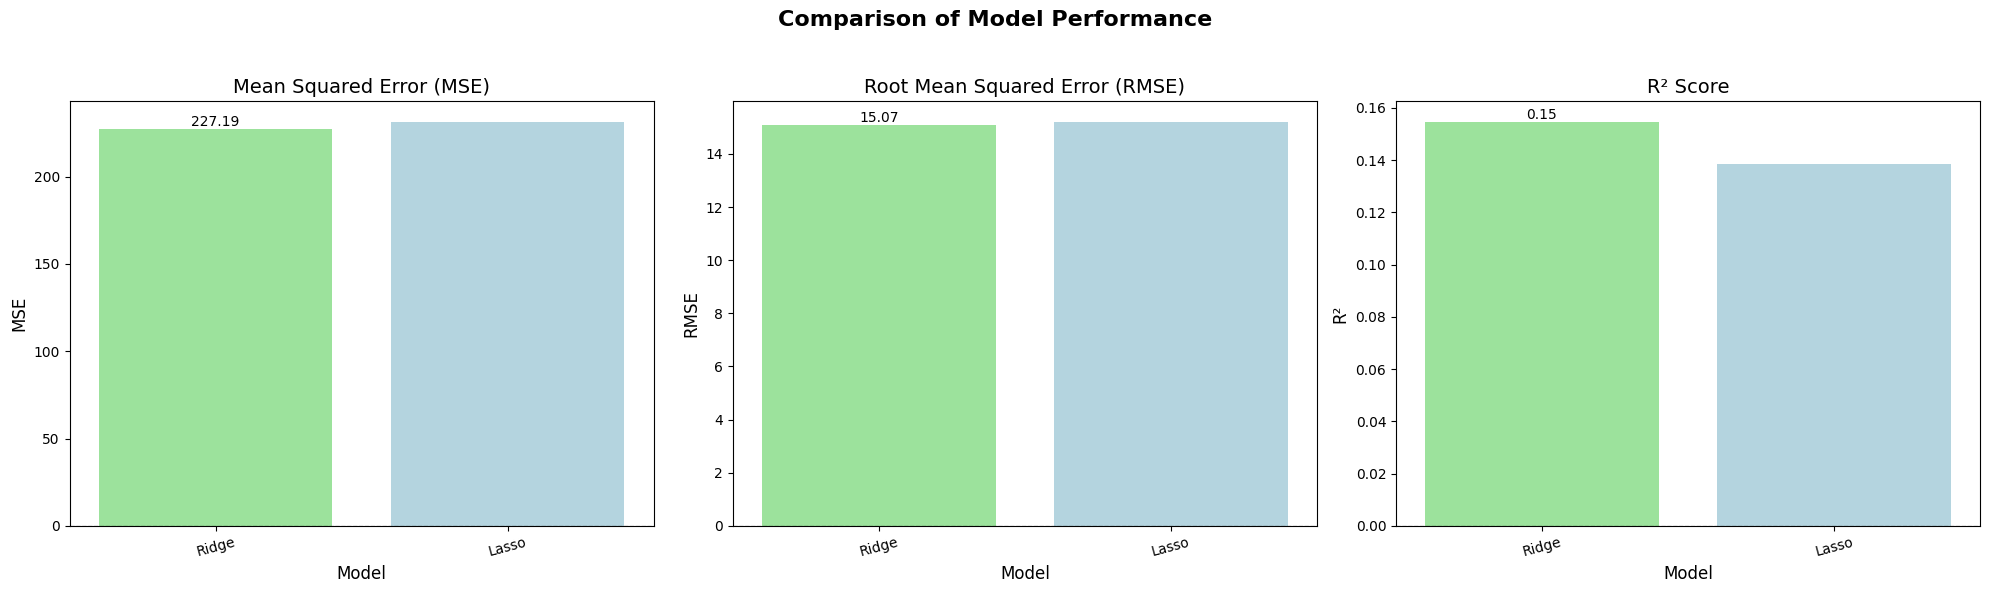


Comparison of Models:
Ridge - MSE: 227.1886, RMSE: 15.0728, R²: 0.1548
Lasso - MSE: 231.5778, RMSE: 15.2177, R²: 0.1385


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Lưu các kết quả của 3 mô hình vào một dictionary
results = {
    'Model': ['Ridge', 'Lasso'],
    'R²': [ridge_test_r2, lasso_test_r2],
    'MSE': [ridge_test_mse, lasso_test_mse],
    'RMSE': [ridge_test_rmse, lasso_test_rmse]
}

# Chọn mô hình tốt nhất (Dựa trên MSE hoặc R² cao nhất)
best_model_index = np.argmin(results['MSE'])  # Chọn mô hình có MSE thấp nhất
best_model_name = results['Model'][best_model_index]
best_model_r2 = results['R²'][best_model_index]
best_model_mse = results['MSE'][best_model_index]
best_model_rmse = results['RMSE'][best_model_index]

# In kết quả mô hình tốt nhất
print(f"Best Model: {best_model_name}")
print(f"Best Model R²: {best_model_r2}")
print(f"Best Model MSE: {best_model_mse}")
print(f"Best Model RMSE: {best_model_rmse}")

# Vẽ biểu đồ so sánh MSE, RMSE và R² của các mô hình
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Màu sắc để làm nổi bật mô hình tốt nhất
colors = ['lightblue' if i != best_model_index else 'lightgreen' for i in range(len(results['Model']))]

# Biểu đồ MSE
sns.barplot(x=results['Model'], y=results['MSE'], ax=ax[0], palette=colors)
ax[0].set_title('Mean Squared Error (MSE)', fontsize=14)
ax[0].set_xlabel('Model', fontsize=12)
ax[0].set_ylabel('MSE', fontsize=12)
ax[0].bar_label(ax[0].containers[0], fmt='%.2f', fontsize=10)

# Biểu đồ RMSE
sns.barplot(x=results['Model'], y=results['RMSE'], ax=ax[1], palette=colors)
ax[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14)
ax[1].set_xlabel('Model', fontsize=12)
ax[1].set_ylabel('RMSE', fontsize=12)
ax[1].bar_label(ax[1].containers[0], fmt='%.2f', fontsize=10)

# Biểu đồ R²
sns.barplot(x=results['Model'], y=results['R²'], ax=ax[2], palette=colors)
ax[2].set_title('R² Score', fontsize=14)
ax[2].set_xlabel('Model', fontsize=12)
ax[2].set_ylabel('R²', fontsize=12)
ax[2].bar_label(ax[2].containers[0], fmt='%.2f', fontsize=10)

# Làm nổi bật mô hình tốt nhất
for a in ax:
    a.axhline(0, color='black', linewidth=0.8, linestyle='--')
    a.tick_params(axis='x', labelrotation=15)

plt.suptitle('Comparison of Model Performance', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# In bảng kết quả để so sánh
print("\nComparison of Models:")
for model, mse, rmse, r2 in zip(results['Model'], results['MSE'], results['RMSE'], results['R²']):
    print(f"{model} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


- Both Ridge and Lasso models exhibit relatively similar performance as measured by MSE and RMSE. This suggests that both models are making predictions with a comparable level of accuracy.
- Ridge has a slightly higher R-squared value, indicating that it explains a slightly greater proportion of the variance in the target variable. This could imply that Ridge is a better fit for the data or that it has identified more relevant features.